In [1]:
# Spark imports
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import DataFrame, Row
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import desc
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, expr, concat, udf, array_contains
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import ArrayType, StringType, FloatType, IntegerType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import DoubleType

# Others
from csv import reader
import csv
import os
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

Investigate the original dataset (obviously, it cannot be used). Take a look at https://stackoverflow.com/questions/13793529/r-error-invalid-type-list-for-variable to see how useless the Body column information could be!

The point here is that the body information consists mostly of codes and some weird patterns that are not useful for our purpose. The most important information here is the connection between the title of the questions and tags. So, we removed the Body column from the dataset.

For removing the Body column, we read all the dataset once using Pandas library. After that, we removed the column and got an export to have a concrete file as our dataset. This part has been ommited from the notebook.

In [3]:
spark = init_spark()
spark.catalog.clearCache()

filename = "./TrainWithoutBody.csv"
df1 = spark.read.option("multiLine", 'true').option("escape","\'").csv(filename, header=True)
df1 = df1.drop("_c0")
df1 = df1.dropna()
rddTags = df1.select("Tags").rdd

df1.count()

6017243

In [4]:
splittedTags1 = rddTags.filter(lambda r: r[0] != None).flatMap(lambda r: r[0].split(" ")).map(lambda r: (r, 1)).reduceByKey(lambda x, y: x + y)
splittedTags1 = splittedTags1.sortBy(lambda r: r[1], False) #Sorted with number of usage (you can collect and see)
splittedTagsSorted1 = splittedTags1.map(lambda r: r[0]) #Delete this line if you want to see number of times they have been used.
mostUsedTags_validation = splittedTagsSorted1.collect()[0:50]

# Finding the 100 most used tags (one DT per each most used tag)

In [5]:
splittedTags = rddTags.filter(lambda r: r[0] != None).flatMap(lambda r: r[0].split(" ")).map(lambda r: r.replace(".", "")).map(lambda r: (r, 1)).reduceByKey(lambda x, y: x + y)
splittedTags = splittedTags.sortBy(lambda r: r[1], False) #Sorted with number of usage (you can collect and see)

### Tag v/s Count Distribution for all tags

+-------------+------+
|          tag| count|
+-------------+------+
|           c#|461574|
|         java|410466|
|          php|390630|
|   javascript|364076|
|      android|319310|
|       jquery|304343|
|          c++|198261|
|       python|183945|
|       iphone|182853|
|       aspnet|176610|
|        mysql|171367|
|         html|164795|
|          net|161728|
|          ios|135545|
|  objective-c|133391|
|          sql|131850|
|          css|128586|
|        linux|127003|
|ruby-on-rails|116184|
|      windows| 97652|
+-------------+------+
only showing top 20 rows



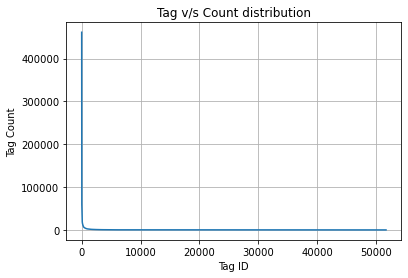

In [6]:
tagCountDF = splittedTags.toDF(["tag", "count"])
tagCountDF.show()
cCount = tagCountDF.select("count").collect()
plt.plot([i for i in range(splittedTags.count())], cCount)
plt.title("Tag v/s Count distribution")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the top 500 tags

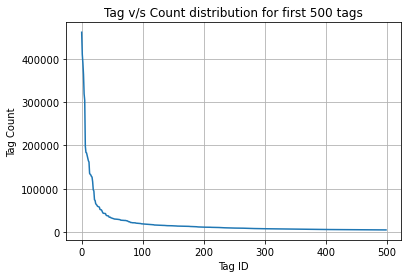

In [7]:
plt.plot([i for i in range(500)], cCount[:500])
plt.title("Tag v/s Count distribution for first 500 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the top 100 tags

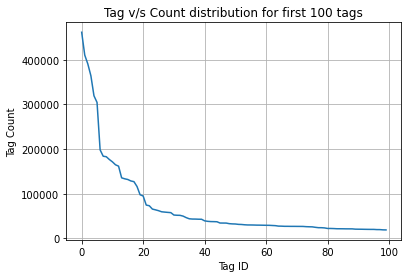

In [8]:
plt.plot([i for i in range(100)], cCount[:100])
plt.title("Tag v/s Count distribution for first 100 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the 10 best tags

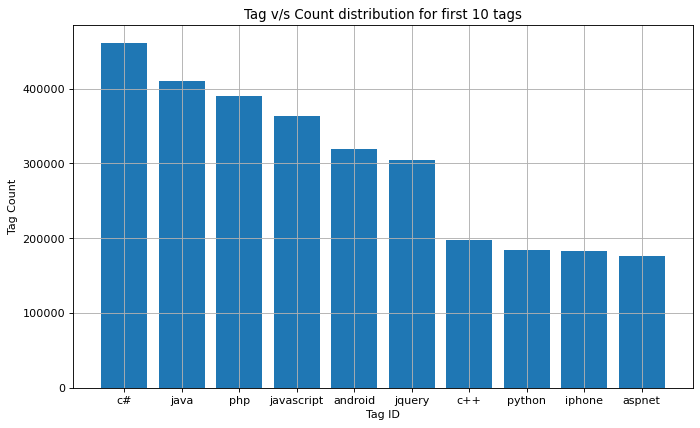

In [9]:
cTag = tagCountDF.select("tag").take(10)

plt.figure(figsize=(10, 6), dpi=80)
plt.bar([i for i in range(10)], [r.__getitem__("count") for r in cCount[:10]], tick_label=[r.__getitem__("tag") for r in cTag])
plt.title("Tag v/s Count distribution for first 10 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

In [10]:
splittedTagsSorted = splittedTags.map(lambda r: r[0]) #Delete this line if you want to see number of times they have been used.
mostUsedTags = splittedTagsSorted.collect()[0:50]
# uncomment bellow to display all mostUsedTags
# mostUsedTags

# TF-IDF Title

## Sampling

In [11]:
df1 = df1.sample(0.001, 42)
data_sampled = df1

## Clean up tags to include only most-used tags

In [12]:
def cleanUpTags(tags):
    tags = tags.split(" ")
    tags = [tag for tag in tags if tag in mostUsedTags]
    return tags

cleanUpTagsUDF = udf(cleanUpTags, ArrayType(StringType()))

df1 = df1.withColumn("cleantags",  cleanUpTagsUDF(col("tags")))

## Remove questions that do not include the top 50 tags

In [13]:
def filterEmptyRows(tags):
    return len(tags)

filterEmptyRowsUDF = udf(filterEmptyRows, IntegerType())

df1 = df1.filter(filterEmptyRowsUDF(col("cleantags")) > 0)

## Subject titles to TF-IDF

In [14]:
tokenizer = Tokenizer(inputCol="Title", outputCol="transformed_Title")
wordsData = tokenizer.transform(df1)

hashingTF = HashingTF(inputCol="transformed_Title", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
df1 = idfModel.transform(featurizedData)

## Add 0/1 column for each tag

In [15]:
for tag in mostUsedTags:
    df1 = df1.withColumn(tag, (array_contains(col("cleantags"), tag)).cast('integer'))

df1.select("cleantags", "c#").show()

+--------------------+---+
|           cleantags| c#|
+--------------------+---+
|                [c#]|  1|
|                [c#]|  1|
|     [php, facebook]|  0|
|           [android]|  0|
|                [c#]|  1|
|               [c++]|  0|
|            [python]|  0|
|     [java, android]|  0|
|                [c#]|  1|
|        [php, mysql]|  0|
|[java, android, e...|  0|
|       [objective-c]|  0|
|        [php, mysql]|  0|
|[ruby-on-rails, r...|  0|
|               [c++]|  0|
|           [android]|  0|
|           [android]|  0|
|               [ios]|  0|
|           [c#, sql]|  1|
|           [android]|  0|
+--------------------+---+
only showing top 20 rows



## Split data to train and test sets

In [16]:
train_data, test_data = df1.randomSplit([.7,.3],seed=1234)

# Train models

### Handling class imbalance using undersampling method

In [17]:
def underSample(training_data, etag):
    major_df = training_data.filter(col(etag) == 0)
    minor_df = training_data.filter(col(etag) == 1)
    ratio = int(major_df.count()/minor_df.count())
    
    sampled_majority_df = major_df.sample(False, 1/ratio)
    train_data = sampled_majority_df.unionAll(minor_df)
    
    return train_data

<h3> Handling class imbalance with assigning class weights (higher weight to minority class) 

In [18]:
def classWeight(training_data, etag):
    balancingRatio = training_data.filter(col(etag) == 1).count() / training_data.count()
    calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())
    
    training_data = training_data.withColumn("classWeightCol", calculateWeights(col(etag)))
    
    return training_data

def trainDTWithUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup

    model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini", weightCol="classWeightCol").fit(training_data)

    # Using model without assigning classweight
    # model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini").fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))

    return model, pred, precision * 100, recall * 100, f1

def trainDTWithoutUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup

    model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini").fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))

    return model, pred, precision * 100, recall * 100, f1

def trainLRWithUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup
    model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100, weightCol="classWeightCol").fit(training_data)

    # Using model without assigning classweight
    # model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100).fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))
    
    return model, pred, precision * 100, recall * 100, f1

def trainLRWithoutUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100).fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))
    
    return model, pred, precision * 100, recall * 100, f1

## Train models for each tag and obtain precision, recall, and f-measure

### Train Decision Tree Models

In [19]:
dtcs = defaultdict()
preds = defaultdict()
precisions = defaultdict()
recalls = defaultdict()
fmeasures = defaultdict()

In [20]:


for tag in mostUsedTags:
    if tag not in dtcs:
        try:
            dtcs[tag], preds[tag], precisions[tag], recalls[tag], fmeasures[tag] = trainDTWithUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))


for tag in mostUsedTags:
    if tag not in dtcs:
        try:
            dtcs[tag], preds[tag], precisions[tag], recalls[tag], fmeasures[tag] = trainDTWithoutUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))


c#
java
php
javascript
android
jquery
c++
python
iphone
aspnet
mysql
html
net
ios
objective-c
sql
css
linux
ruby-on-rails
windows
c
sql-server
ruby
wpf
xml
ajax
database
regex
windows-7
aspnet-mvc
xcode
django
osx
arrays
vbnet
eclipse
json
facebook
ruby-on-rails-3
ubuntu
performance
networking
string
multithreading
winforms
security
aspnet-mvc-3
visual-studio-2010
bash
homework


### Train Logistic Regression Models

In [21]:
dtcs1 = defaultdict()
preds1 = defaultdict()
precisions1 = defaultdict()
recalls1 = defaultdict()
fmeasures1 = defaultdict()

In [22]:
for tag in mostUsedTags:
    if tag not in dtcs1:
        try:
            dtcs1[tag], preds1[tag], precisions1[tag], recalls1[tag], fmeasures1[tag] = trainLRWithUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))

for tag in mostUsedTags:
    if tag not in dtcs1:
        try:
            dtcs1[tag], preds1[tag], precisions1[tag], recalls1[tag], fmeasures1[tag] = trainLRWithoutUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))

c#
java
php
javascript
android
jquery
c++
python
iphone
Passed: aspnet
mysql
html
Passed: net
ios
objective-c
sql
css
linux
ruby-on-rails
windows
c
sql-server
ruby
wpf
xml
ajax
database
regex
windows-7
Passed: aspnet-mvc
xcode
django
osx
arrays
Passed: vbnet
eclipse
json
facebook
ruby-on-rails-3
ubuntu
performance
networking
string
multithreading
winforms
security
Passed: aspnet-mvc-3
visual-studio-2010
bash
homework
aspnet
net
aspnet-mvc
vbnet
aspnet-mvc-3


In [23]:
print(precisions)
print(recalls)
print(fmeasures)

defaultdict(None, {'c#': 94.11764705882352, 'java': 100.0, 'php': 65.51724137931035, 'javascript': 52.307692307692314, 'android': 100.0, 'jquery': 79.66101694915254, 'c++': 89.47368421052632, 'python': 29.166666666666668, 'iphone': 65.21739130434783, 'aspnet': 0, 'mysql': 40.0, 'html': 47.22222222222222, 'net': 0, 'ios': 25.71428571428571, 'objective-c': 3.7037037037037033, 'sql': 36.11111111111111, 'css': 61.904761904761905, 'linux': 23.404255319148938, 'ruby-on-rails': 15.686274509803921, 'windows': 16.216216216216218, 'c': 19.35483870967742, 'sql-server': 27.500000000000004, 'ruby': 45.0, 'wpf': 88.88888888888889, 'xml': 41.37931034482759, 'ajax': 10.256410256410255, 'database': 10.81081081081081, 'regex': 93.33333333333333, 'windows-7': 10.714285714285714, 'aspnet-mvc': 0, 'xcode': 6.0606060606060606, 'django': 30.76923076923077, 'osx': 66.66666666666666, 'arrays': 14.583333333333334, 'vbnet': 0, 'eclipse': 37.5, 'json': 17.02127659574468, 'facebook': 100.0, 'ruby-on-rails-3': 18.7

# Word2Vec Title

Now we will be training the same models. This time however we will be using Word2Vec for the featurization of the titles. 

We first start by defining some constants and some utility functions.

In [24]:
num_labels = 50
classifier_array_title = []

def column_splitter(r):
    if not r.Tags:
        label_array = None
    else:
        tags = r.Tags.split(' ')
        label_array = []
        for t in mostUsedTags_validation:
            if t in tags:
                label_array.append(1)
            else:
                label_array.append(0)
        if 1 not in label_array:
            label_array = None
    
    return (r.Id, r.Title, r.Tags, r.transformed_Title, label_array)


def init_spark_2():
    spark = SparkSession \
        .builder.appName("W2V with Title").config("spark.sql.broadcastTimeout", "72000").config('spark.shuffle.service.enabled', 'TRUE').config("spark.debug.maxToStringFields" , "100").config("spark.executor.heartbeatInterval", "14400").getOrCreate()
        
    return spark

We then can conveniently take a previously processed dataframe with the sample set. We then need to tokenize the title.

In [25]:
spark = init_spark_2()

w2v_data_title = data_sampled

wordsData = tokenizer.transform(w2v_data_title)


## Data Pre-processing

### Current State of Dataframe


In [26]:
wordsData.take(1)    

[Row(Id='7283', Title='C# timers for moving objects', Tags='c# animation timer movement ticker', transformed_Title=['c#', 'timers', 'for', 'moving', 'objects'])]

We want to turn all arrays of tags into a binary array of length 50 where every index is a 1 if it's corressponding tag is in this row, 0 otherwise

We also rename the columns accordingly and then drop all rows that do not hold any tags

In [27]:
wordsData = wordsData.rdd.map(lambda r: column_splitter(r))
wordsData = wordsData.toDF(['Id', 'Title', 'Tags', 'transformed_Title', 'tag_array'])
wordsData = wordsData.dropna()

wordsData.take(1)    

[Row(Id='7283', Title='C# timers for moving objects', Tags='c# animation timer movement ticker', transformed_Title=['c#', 'timers', 'for', 'moving', 'objects'], tag_array=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

### Data Featurization, Sampling and Structure

We split the sampled data into a test and training set.

In [28]:
train_df_pre_title, test_df_pre_title = wordsData.randomSplit([.7,.3],seed=1234)

We then featurize the Title column using W2V and fit model with the whole dataset.

We finish off this section by transforming the test and train datasets with the W2V model

In [29]:
word2Vec = Word2Vec(inputCol="transformed_Title", outputCol="features", vectorSize=100)
fitted_word2Vec = word2Vec.fit(wordsData)

train_df_pre_title = fitted_word2Vec.transform(train_df_pre_title)
test_df_pre_title = fitted_word2Vec.transform(test_df_pre_title)

In [30]:
spark.catalog.clearCache()
train_df_pre_title.take(1)

[Row(Id='1003396', Title='Show values of custom field created with ACF on a page', Tags='php custom-field', transformed_Title=['show', 'values', 'of', 'custom', 'field', 'created', 'with', 'acf', 'on', 'a', 'page'], tag_array=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], features=DenseVector([-0.0159, -0.03, 0.0041, 0.0395, 0.011, -0.0024, 0.0114, -0.0348, -0.008, 0.0125, 0.0083, 0.0396, -0.0198, -0.0138, -0.0111, 0.0204, 0.0219, -0.0007, 0.006, -0.002, 0.0199, 0.0065, 0.0085, 0.0183, -0.0263, 0.0298, -0.0235, 0.0083, -0.013, 0.018, -0.011, -0.0002, -0.0402, -0.0161, 0.0101, 0.0049, -0.0173, 0.0193, 0.0051, 0.0373, 0.0068, -0.0239, 0.0117, -0.0406, -0.0057, 0.0171, 0.0039, 0.0142, 0.0118, -0.0001, -0.0052, 0.0245, -0.0292, 0.0108, 0.0003, -0.0228, 0.0128, -0.0151, -0.0392, 0.0311, 0.0331, -0.0059, -0.0076, -0.0302, -0.0036, 0.0303, -0.0122, -0.0427, 0.0227, -0.0152, 0.009, -0.0302,

### Seperate Label Array into Columns

We want there to be a column for each tag so that we can train each classifier based on the target of that models respective tag.

We start off by performing the necessary actions on first the train data set.

In [31]:
train_df_title = train_df_pre_title.select(['Id']+['Title']+['Tags']+['transformed_Title']+['features']+[expr('tag_array[' + str(x) + ']') for x in range(0, num_labels)])

for i in range(0, num_labels): 
    if '.' in mostUsedTags[i]:
        mostUsedTags[i] = mostUsedTags[i].replace('.', '')

colnames = ['Id']+['Title']+['Tags']+['transformed_Title']+['features']+ [str(mostUsedTags[i]) for i in range(0, num_labels)] 
train_df_title = train_df_title.toDF(*colnames)

train_data = train_df_title

train_data.take(1)

[Row(Id='1003396', Title='Show values of custom field created with ACF on a page', Tags='php custom-field', transformed_Title=['show', 'values', 'of', 'custom', 'field', 'created', 'with', 'acf', 'on', 'a', 'page'], features=DenseVector([-0.0159, -0.03, 0.0041, 0.0395, 0.011, -0.0024, 0.0114, -0.0348, -0.008, 0.0125, 0.0083, 0.0396, -0.0198, -0.0138, -0.0111, 0.0204, 0.0219, -0.0007, 0.006, -0.002, 0.0199, 0.0065, 0.0085, 0.0183, -0.0263, 0.0298, -0.0235, 0.0083, -0.013, 0.018, -0.011, -0.0002, -0.0402, -0.0161, 0.0101, 0.0049, -0.0173, 0.0193, 0.0051, 0.0373, 0.0068, -0.0239, 0.0117, -0.0406, -0.0057, 0.0171, 0.0039, 0.0142, 0.0118, -0.0001, -0.0052, 0.0245, -0.0292, 0.0108, 0.0003, -0.0228, 0.0128, -0.0151, -0.0392, 0.0311, 0.0331, -0.0059, -0.0076, -0.0302, -0.0036, 0.0303, -0.0122, -0.0427, 0.0227, -0.0152, 0.009, -0.0302, -0.0078, 0.0136, -0.0121, 0.0319, 0.0153, -0.0255, -0.0071, -0.0067, 0.0023, -0.0182, 0.0222, -0.0008, -0.0111, -0.0083, 0.0011, 0.0201, -0.0203, -0.0049, -0.034

And then on the test data set.

In [32]:
test_df_pre_title = test_df_pre_title.select(['Id']+['Title']+['Tags']+['transformed_Title']+['features']+[expr('tag_array[' + str(x) + ']') for x in range(0, num_labels)])

for i in range(0, num_labels): 
    if '.' in mostUsedTags[i]:
        mostUsedTags[i] = mostUsedTags[i].replace('.', '')

colnames = ['Id']+['Title']+['Tags']+['transformed_Title']+['features']+ [str(mostUsedTags[i]) for i in range(0, num_labels)] 
test_df_pre_title = test_df_pre_title.toDF(*colnames)

test_data = test_df_pre_title

test_data.take(1)

[Row(Id='1000084', Title='Java Data Structures Reference', Tags='java data-structures time-complexity summary', transformed_Title=['java', 'data', 'structures', 'reference'], features=DenseVector([-0.0102, -0.0158, 0.0016, 0.0213, 0.0068, -0.0033, 0.0048, -0.0223, -0.0071, 0.0031, 0.0047, 0.0218, -0.0053, -0.0054, -0.0116, 0.009, 0.0144, -0.0045, 0.0035, 0.0011, 0.0148, 0.0046, 0.0085, 0.0145, -0.0203, 0.0218, -0.0079, 0.0042, -0.0043, 0.0106, -0.0112, 0.0038, -0.0231, -0.0087, 0.0066, -0.0009, -0.0117, 0.006, 0.0019, 0.0202, 0.0032, -0.0183, 0.0065, -0.0296, -0.0107, 0.0152, -0.0018, 0.0085, 0.0037, -0.0035, 0.0, 0.0115, -0.0149, 0.0041, 0.0031, -0.0148, 0.0057, -0.0054, -0.0236, 0.0196, 0.0148, -0.0013, -0.0003, -0.018, -0.0005, 0.0151, -0.0063, -0.0187, 0.0165, -0.0118, 0.0067, -0.0168, 0.002, 0.0075, -0.0032, 0.0189, 0.006, -0.0122, -0.0059, -0.0097, 0.004, -0.0104, 0.0213, -0.0016, -0.0065, -0.0083, 0.0031, 0.0111, -0.0093, -0.0025, -0.0171, 0.0091, -0.0111, -0.0052, -0.0083, -0.0

## Train Models

We create dictionaries for the models and their respective metrics. This is in case the for loops that train the models ever crash. If they crash we will still have the dictionaries and the for loops can save time by only training the models and getting their predictions if it hasn't been done so already.

In [33]:
w2v_lrs = defaultdict()
w2v_lrs_preds = defaultdict()
w2v_lrs_precisions = defaultdict()
w2v_lrs_recalls = defaultdict()
w2v_lrs_fmeasures = defaultdict()

w2v_dts = defaultdict()
w2v_dts_preds = defaultdict()
w2v_dts_precisions = defaultdict()
w2v_dts_recalls = defaultdict()
w2v_dts_fmeasures = defaultdict()

We first train the Logistric Regression models. We run two loops, one with under sampling and one without. This is because under sampling can sometimes bring up errors so if a specific tag's model is not trained because of that it will be trained later on by the second loop

In [34]:
for tag in mostUsedTags:
    if tag not in w2v_lrs:
        try:
            w2v_lrs[tag], w2v_lrs_preds[tag], w2v_lrs_precisions[tag], w2v_lrs_recalls[tag], w2v_lrs_fmeasures[tag] = trainLRWithUndersampling(train_data, tag) 
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

for tag in mostUsedTags:
    if tag not in w2v_lrs:
        try:
            w2v_lrs[tag], w2v_lrs_preds[tag], w2v_lrs_precisions[tag], w2v_lrs_recalls[tag], w2v_lrs_fmeasures[tag] = trainLRWithoutUndersampling(train_data, tag) 
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

Trained: c#
Trained: java
Trained: php
Trained: javascript
Trained: android
Trained: jquery
Trained: c++
Trained: python
Trained: iphone
Trained: aspnet
Trained: mysql
Trained: html
Trained: net
Trained: ios
Trained: objective-c
Trained: sql
Trained: css
Trained: linux
Trained: ruby-on-rails
Trained: windows
Trained: c
Trained: sql-server
Trained: ruby
Trained: wpf
Trained: xml
Trained: ajax
Trained: database
Trained: regex
Trained: windows-7
Trained: aspnet-mvc
Trained: xcode
Trained: django
Trained: osx
Trained: arrays
Trained: vbnet
Trained: eclipse
Trained: json
Trained: facebook
Trained: ruby-on-rails-3
Trained: ubuntu
Trained: performance
Trained: networking
Trained: string
Trained: multithreading
Trained: winforms
Trained: security
Trained: aspnet-mvc-3
Trained: visual-studio-2010
Trained: bash
Trained: homework


We do the same thing but this time with the Decision Trees.

In [35]:
for tag in mostUsedTags:
    if tag not in w2v_dts:
        try:
            w2v_dts[tag], w2v_dts_preds[tag], w2v_dts_precisions[tag], w2v_dts_recalls[tag], w2v_dts_fmeasures[tag] = trainDTWithUndersampling(train_data, tag)
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

for tag in mostUsedTags:
    if tag not in w2v_dts:
        try:
            w2v_dts[tag], w2v_dts_preds[tag], w2v_dts_precisions[tag], w2v_dts_recalls[tag], w2v_dts_fmeasures[tag] = trainDTWithoutUndersampling(train_data, tag)
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

Trained: c#
Trained: java
Trained: php
Trained: javascript
Trained: android
Trained: jquery
Trained: c++
Trained: python
Trained: iphone
Trained: aspnet
Trained: mysql
Trained: html
Trained: net
Trained: ios
Trained: objective-c
Trained: sql
Trained: css
Trained: linux
Trained: ruby-on-rails
Trained: windows
Trained: c
Trained: sql-server
Trained: ruby
Trained: wpf
Trained: xml
Trained: ajax
Trained: database
Trained: regex
Trained: windows-7
Trained: aspnet-mvc
Trained: xcode
Trained: django
Trained: osx
Trained: arrays
Trained: vbnet
Trained: eclipse
Trained: json
Trained: facebook
Trained: ruby-on-rails-3
Trained: ubuntu
Trained: performance
Trained: networking
Trained: string
Trained: multithreading
Trained: winforms
Trained: security
Trained: aspnet-mvc-3
Trained: visual-studio-2010
Trained: bash
Trained: homework


# Display Functions

In [37]:
def results_to_plot_data(res):
    array =[]
    for tag in mostUsedTags:
        try:
            array.append(res[tag])
        except:
            array.append(0)
    return array

def display_precision():
    plt.figure(figsize=[20, 10])
    labels = mostUsedTags
    x = np.arange(len(labels))  # the label locations
    
    data1 = results_to_plot_data(precisions)
    data2 = results_to_plot_data(precisions1)
    data3 = results_to_plot_data(w2v_lrs_precisions)
    data4 = results_to_plot_data(w2v_dts_precisions)

    plt.bar(x - 0.2, data1, 0.2, label = 'TF-IDF/Decistion Tree')
    plt.bar(x - 0.1, data2, 0.2, label = 'TF-IDF/Logistic Regression')
    plt.bar(x + 0.1, data3, 0.2, label = 'W2V/Decistion Tree')
    plt.bar(x + 0.2, data4, 0.2, label = 'W2V/Logistic Regression')
    plt.xticks(x, x)
    plt.xlabel("Groups")
    plt.ylabel("Precision (%)")
    plt.title("Precision According to Model and Featurization Method")
    plt.legend()
    plt.show()

def display_recall():
    plt.figure(figsize=[20, 10])
    labels = mostUsedTags
    x = np.arange(len(labels))  # the label locations
    
    data1 = results_to_plot_data(recalls)
    data2 = results_to_plot_data(recalls1)
    data3 = results_to_plot_data(w2v_lrs_recalls)
    data4 = results_to_plot_data(w2v_dts_recalls)

    plt.bar(x - 0.2, data1, 0.2, label = 'TF-IDF/Decistion Tree')
    plt.bar(x - 0.1, data2, 0.2, label = 'TF-IDF/Logistic Regression')
    plt.bar(x + 0.1, data3, 0.2, label = 'W2V/Decistion Tree')
    plt.bar(x + 0.2, data4, 0.2, label = 'W2V/Logistic Regression')
    plt.xticks(x, x)
    plt.xlabel("Groups")
    plt.ylabel("Recall")
    plt.title("Recall According to Model and Featurization Method")
    plt.legend()
    plt.show()

def display_f1():
    plt.figure(figsize=[20, 10])
    labels = mostUsedTags
    x = np.arange(len(labels))  # the label locations
    
    data1 = results_to_plot_data(fmeasures)
    data2 = results_to_plot_data(fmeasures1)
    data3 = results_to_plot_data(w2v_lrs_fmeasures)
    data4 = results_to_plot_data(w2v_dts_fmeasures)

    plt.bar(x - 0.2, data1, 0.2, label = 'TF-IDF/Decistion Tree')
    plt.bar(x - 0.1, data2, 0.2, label = 'TF-IDF/Logistic Regression')
    plt.bar(x + 0.1, data3, 0.2, label = 'W2V/Decistion Tree')
    plt.bar(x + 0.2, data4, 0.2, label = 'W2V/Logistic Regression')
    plt.xticks(x, x)
    plt.xlabel("Groups")
    plt.ylabel("F1 score")
    plt.title("F1 score According to Model and Featurization Method")
    plt.legend()
    plt.show()

# Conclusion

First lets visualize the resulting metrics of all 4 types of models.

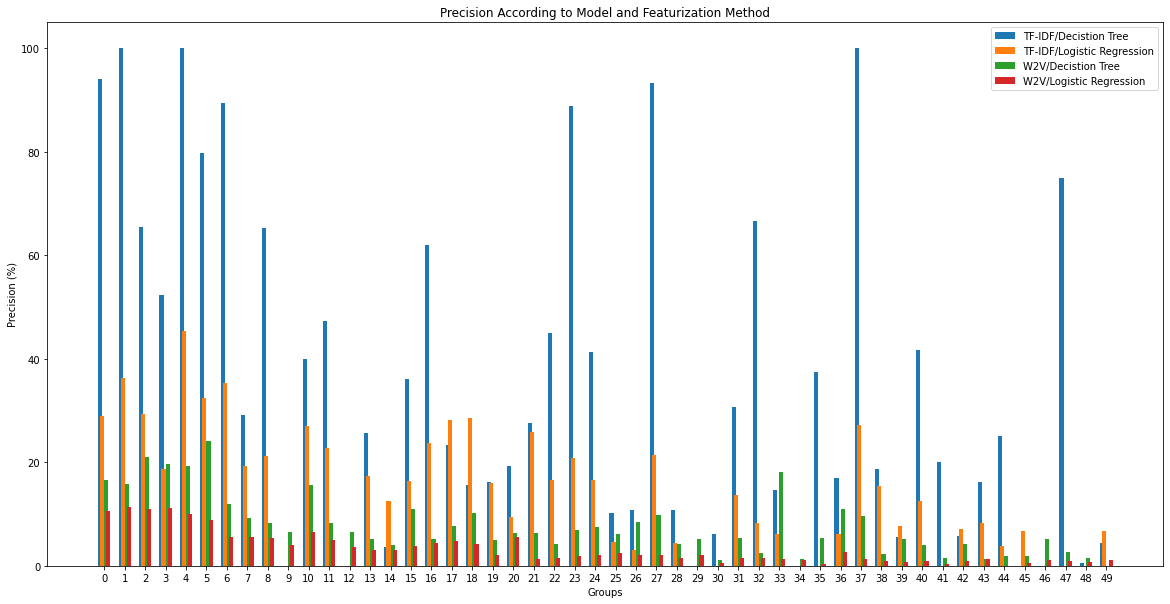

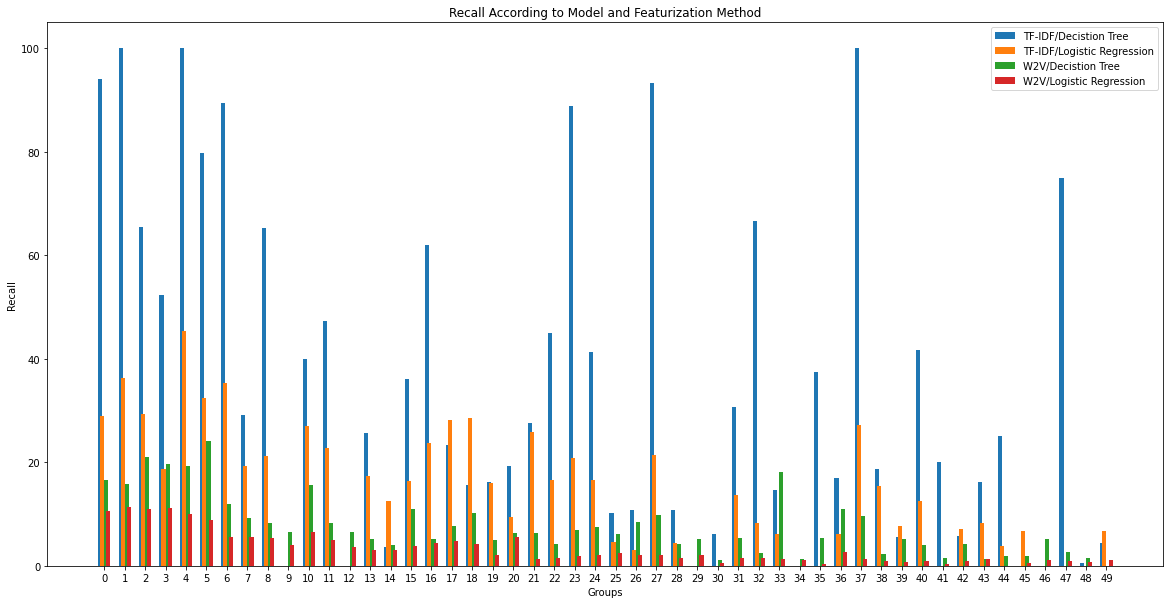

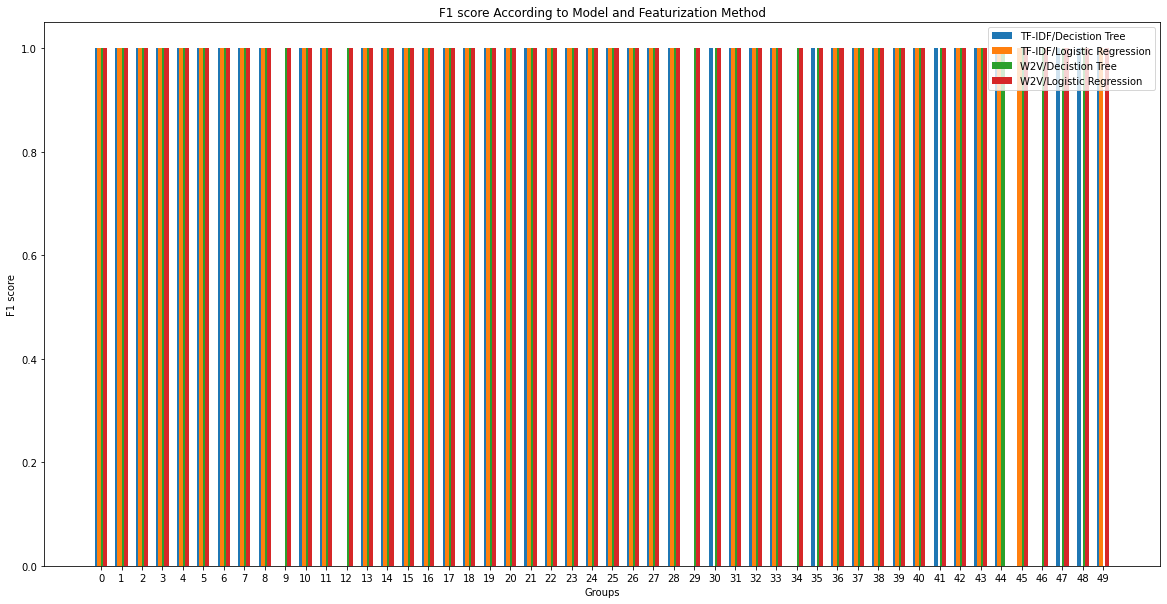

In [38]:
display_precision()
display_recall()
display_f1()

Given the relatively small size of our dataset and the daunting task that multi-label classification poses we are quite happy with our results. There are quite a few obvious ways however that we could've improved our models given the time and resources. 

The first of which being the optimization of each models parameters. Given the ability to run this same experiment with a plethora of parameter configurations, we could truly optimize our models to give them the best chance of succeeding. For example W2V has quite a difference in performance when utilizing different vector sizes and TF-IDF as well in relation to the number of features. The same can be said for the maxiterations of Logistic Regression models and the maxdepth of Decision Trees.

The next thing that could've been improved is the amount of data that we used. Since we only used 0.1 percent of the data, it would be quite interesting to see what results using more would bring. Word Embeddings work quite well when given a large amount of quality data. Going on this point of quality data, implementing a filter for stop words in our pipeline would also be quite interesting. And lastly on the topic of improvements of data, including the body of the dataset questions would prove to be quite interesting as well. If stop-words are removed, the body could contain incredibly important keywords that when featurized could results in huge bounds in results. 

Further work however, would need to utilized some sort of data bricking and cloud implementation, or at least parallelization, as the most frequent errors encountered were almost always timeout errors or memory errors. On top of that the long wait time for even the small dataset we used makes it incredibly hard to run many tests to then compare as the entire suite on a fraction of the dataset takes hours.

# References

https://github.com/96malhar/StackOverflow-Tag-Prediction

https://www.datatechnotes.com/2021/06/pyspark-decision-tree-classification.html

https://spark.apache.org/docs/latest/mllib-feature-extraction.html 

https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.Word2Vec.html